In [27]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
import json
import nltk
import unicodedata
import re
import string
import joblib as joblib
import pickle as pickle


In [28]:
#Load data
data = pd.read_csv('fakenews.csv')

In [29]:
# Count the number of rows before removing duplicates
num_rows_before = len(data)

# Remove duplicates
data.drop_duplicates(inplace=True)

# Count the number of rows after removing duplicates
num_rows_after = len(data)

print("Number of rows before removing duplicates:", num_rows_before)
print("Number of rows after removing duplicates:", num_rows_after)

Number of rows before removing duplicates: 3206
Number of rows after removing duplicates: 3005


In [30]:
X = data['article']
y = data['label']

In [31]:
# Split the data into train (90%) and test (10%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

# Split the train set into train (70%) and validation (30%) sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, random_state=42)

In [32]:
# Show the number of rows for train, test, and validation sets
print("Train set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

Train set size: 1892
Validation set size: 812
Test set size: 301


In [33]:
# Count the occurrences of each class label in train, test, and validation sets
train_label_counts = y_train.value_counts()
test_label_counts = y_test.value_counts()
val_label_counts = y_val.value_counts()

print("\nTrain set label counts:")
print(train_label_counts)
print("\nTest set label counts:")
print(test_label_counts)
print("\nValidation set label counts:")
print(val_label_counts)


Train set label counts:
label
1    950
0    942
Name: count, dtype: int64

Test set label counts:
label
1    151
0    150
Name: count, dtype: int64

Validation set label counts:
label
1    408
0    404
Name: count, dtype: int64


In [34]:
# # Text preprocessing
# def remove_diacritics(text):
#     normalized = unicodedata.normalize("NFD", text)
#     return "".join(c for c in normalized if unicodedata.category(c) != "Mn")

# def wordopt(text):
#     text = text.lower()
#     text = remove_diacritics(text)
#     text = re.sub('\[.*?\]', '', text)
#     text = re.sub("\\W", " ", text)
#     text = re.sub('https?://\S+|www\.\S+', '', text)
#     text = re.sub('<.*?>+', '', text)
#     text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
#     text = re.sub('\n', '', text)
#     text = re.sub('\w*\d\w*', '', text)
#     return text

# ps = PorterStemmer()
# with open('stopwords-tl.json', 'r') as f:
#     stopwords = json.load(f)

# def preprocess(text):
#     text = wordopt(text)
#     tokens = nltk.word_tokenize(text)
#     stems = [ps.stem(token) for token in tokens]
#     filtered = [stem for stem in stems if stem not in stopwords]
#     return filtered

In [35]:
# Text preprocessing
def remove_diacritics(text):
    normalized = unicodedata.normalize("NFD", text)
    return "".join(c for c in normalized if unicodedata.category(c) != "Mn")

def wordopt(text):
    text = text.lower()
    text = remove_diacritics(text)
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r"\\W", " ", text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

ps = PorterStemmer()
with open('../Datasets/stopwords-tl.json', 'r') as f:
    stopwords = json.load(f)

def preprocess(text):
    text = wordopt(text)
    tokens = nltk.word_tokenize(text)
    stems = [ps.stem(token) for token in tokens]
    filtered = [stem for stem in stems if stem not in stopwords]
    return filtered

In [36]:
# Apply preprocess function to X_train
X_train = X_train.apply(preprocess)

# Apply preprocess function to X_val
X_val = X_val.apply(preprocess)

In [37]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train.apply(lambda x: ' '.join(x)))
X_val_tfidf = vectorizer.transform(X_val.apply(lambda x: ' '.join(x)))

In [38]:
# Initializing base models

mnb = MultinomialNB()
lr = LogisticRegression()
rf = RandomForestClassifier()
knn = KNeighborsClassifier()
svm = SVC(probability=True)

base_models = [mnb, lr, rf, knn, svm]
base_names = ['MNB', 'LR', 'RF', 'KNN', 'SVM']
# base_models = [('MNB', mnb), ('LR', lr), ('RF', rf), ('KNN', knn), ('SVM', svm)]

In [39]:
# Define the parameter grid

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [1, 2, 3, 4, 'sqrt', 'log2']
}

# Define the GridSearchCV
lr_grid = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

In [40]:
lr_grid.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': [1, 2, 3, 4, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [41]:
print("Best parameters: ", lr_grid.best_params_)
print("Accuracy: {:.2f}%".format(lr_grid.best_score_ * 100))

Best parameters:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy: 93.50%


In [42]:
best_meta = lr_grid.best_estimator_

In [43]:
stack = StackingClassifier(estimators=list(zip(base_names, base_models)), final_estimator=best_meta, cv=5)
stack.fit(X_train_tfidf, y_train)

StackingClassifier(cv=5,
                   estimators=[('MNB', MultinomialNB()),
                               ('LR', LogisticRegression()),
                               ('RF', RandomForestClassifier()),
                               ('KNN', KNeighborsClassifier()),
                               ('SVM', SVC(probability=True))],
                   final_estimator=RandomForestClassifier(min_samples_split=5))

Metrics for MNB:
Accuracy: 0.8386699507389163
Precision: 0.7628083491461101
Recall: 0.9852941176470589
F1 Score: 0.8598930481283422
AUC: 0.9788147932440303
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.69      0.81       404
           1       0.76      0.99      0.86       408

    accuracy                           0.84       812
   macro avg       0.87      0.84      0.83       812
weighted avg       0.87      0.84      0.84       812



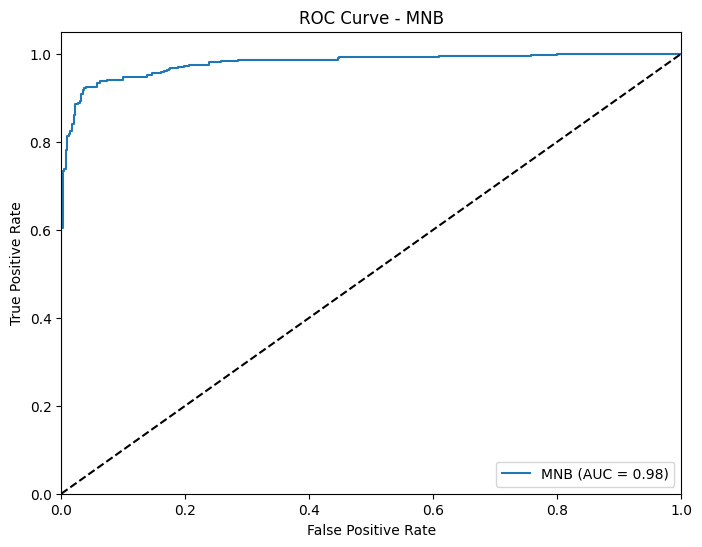

Metrics for LR:
Accuracy: 0.9334975369458128
Precision: 0.9633507853403142
Recall: 0.9019607843137255
F1 Score: 0.9316455696202531
AUC: 0.9862041351193942
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       404
           1       0.96      0.90      0.93       408

    accuracy                           0.93       812
   macro avg       0.94      0.93      0.93       812
weighted avg       0.94      0.93      0.93       812



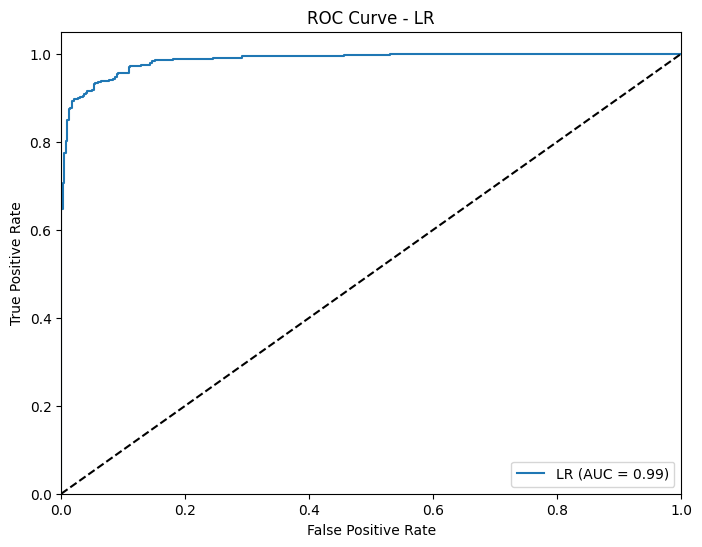

Metrics for RF:
Accuracy: 0.9359605911330049
Precision: 0.9341463414634147
Recall: 0.9387254901960784
F1 Score: 0.9364303178484108
AUC: 0.9846571054164239
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       404
           1       0.93      0.94      0.94       408

    accuracy                           0.94       812
   macro avg       0.94      0.94      0.94       812
weighted avg       0.94      0.94      0.94       812



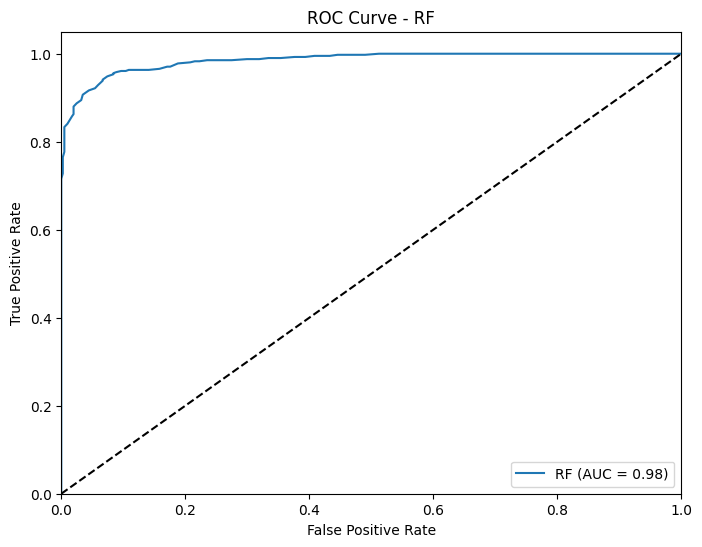

Metrics for KNN:
Accuracy: 0.8768472906403941
Precision: 0.8290598290598291
Recall: 0.9509803921568627
F1 Score: 0.8858447488584474
AUC: 0.9450258444962144
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.80      0.87       404
           1       0.83      0.95      0.89       408

    accuracy                           0.88       812
   macro avg       0.89      0.88      0.88       812
weighted avg       0.89      0.88      0.88       812



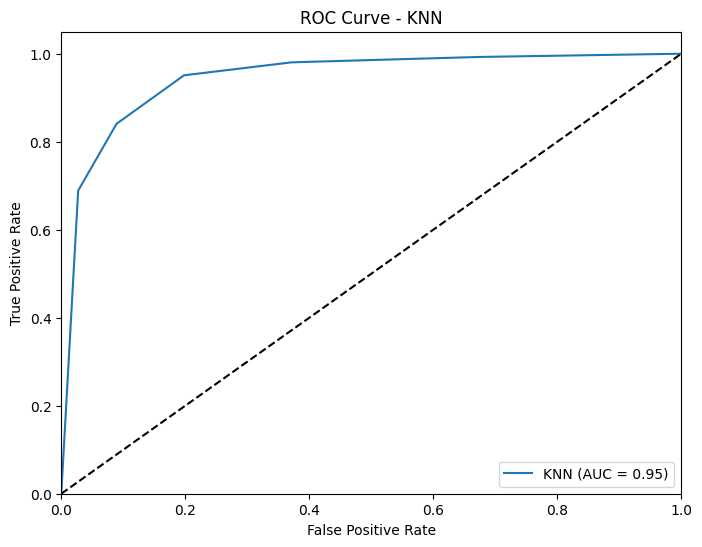

Metrics for SVM:
Accuracy: 0.9433497536945813
Precision: 0.9763157894736842
Recall: 0.9093137254901961
F1 Score: 0.9416243654822335
AUC: 0.9891465249466123
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       404
           1       0.98      0.91      0.94       408

    accuracy                           0.94       812
   macro avg       0.95      0.94      0.94       812
weighted avg       0.95      0.94      0.94       812



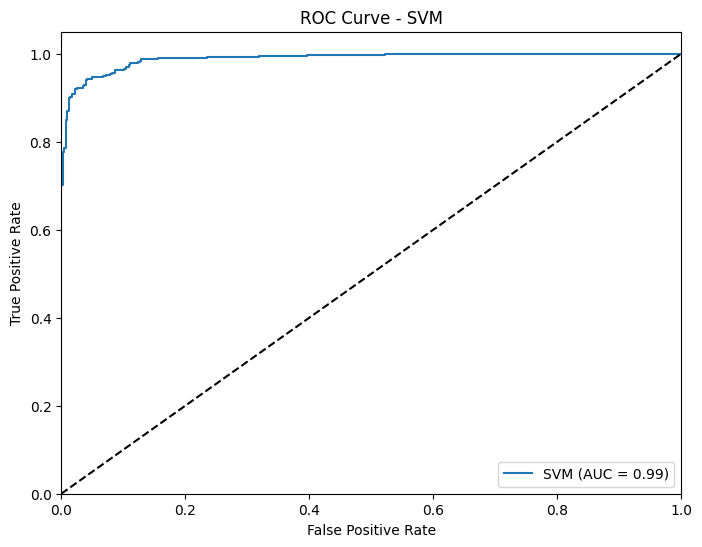

In [44]:
# Create an empty DataFrame for storing metrics
metrics_df = pd.DataFrame(index=base_names + ['Stacking Model'], columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])


# Evaluate base models
for model, name in zip(base_models, base_names):
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_val_tfidf)
    y_prob = model.predict_proba(X_val_tfidf)[:, 1]  # Probability for positive class for ROC curve

    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob)

    print(f"Metrics for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"AUC: {auc}")
    print(f"Classification Report:\n{classification_report(y_val, y_pred)}")

    # Store metrics in the DataFrame
    metrics_df.loc[name] = [accuracy, precision, recall, f1, auc]

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    roc_auc = roc_auc_score(y_val, y_prob)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.show()

Metrics for Stacking Model:
Accuracy: 0.9630541871921182
Precision: 0.9587378640776699
Recall: 0.9681372549019608
F1 Score: 0.9634146341463414
AUC: 0.9934114735002911
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       404
           1       0.96      0.97      0.96       408

    accuracy                           0.96       812
   macro avg       0.96      0.96      0.96       812
weighted avg       0.96      0.96      0.96       812



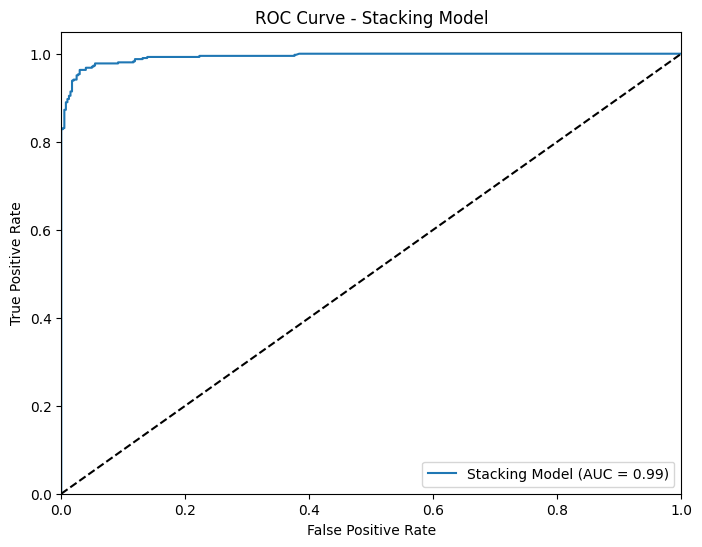

Comparison of Models:
                Accuracy Precision    Recall  F1 Score       AUC
MNB              0.83867  0.762808  0.985294  0.859893  0.978815
LR              0.933498  0.963351  0.901961  0.931646  0.986204
RF              0.935961  0.934146  0.938725   0.93643  0.984657
KNN             0.876847   0.82906   0.95098  0.885845  0.945026
SVM              0.94335  0.976316  0.909314  0.941624  0.989147
Stacking Model  0.963054  0.958738  0.968137  0.963415  0.993411


In [45]:
# Evaluate stacking model
stack_y_pred = stack.predict(X_val_tfidf)
stack_y_prob = stack.predict_proba(X_val_tfidf)[:, 1]  # Probability for positive class for ROC curve

stack_accuracy = accuracy_score(y_val, stack_y_pred)
stack_precision = precision_score(y_val, stack_y_pred)
stack_recall = recall_score(y_val, stack_y_pred)
stack_f1 = f1_score(y_val, stack_y_pred)
stack_auc = roc_auc_score(y_val, stack_y_prob)

print("Metrics for Stacking Model:")
print(f"Accuracy: {stack_accuracy}")
print(f"Precision: {stack_precision}")
print(f"Recall: {stack_recall}")
print(f"F1 Score: {stack_f1}")
print(f"AUC: {stack_auc}")
print(f"Classification Report:\n{classification_report(y_val, stack_y_pred)}")

# ROC Curve for stacking model
stack_fpr, stack_tpr, _ = roc_curve(y_val, stack_y_prob)
stack_roc_auc = roc_auc_score(y_val, stack_y_prob)

# Store stacking model metrics in the DataFrame
metrics_df.loc['Stacking Model'] = [stack_accuracy, stack_precision, stack_recall, stack_f1, stack_auc]


# Plot ROC Curve for stacking model
plt.figure(figsize=(8, 6))
plt.plot(stack_fpr, stack_tpr, label=f'Stacking Model (AUC = {stack_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Stacking Model')
plt.legend(loc="lower right")
plt.show()

# Display the comparison table
print("Comparison of Models:")
print(metrics_df)

In [46]:
# Save the model using joblib
joblib.dump(stack, 'stackmodel_lr_new_more.joblib')

['stackmodel_lr_new_more.joblib']